In [40]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.family'] = 'SimHei'
rcParams['axes.unicode_minus'] = False

class BernoulliBandit:
    """
    伯努利多臂老虎机

    参数:
        K (int): 老虎机的臂(拉杆)数量
        seed (int, optional): 随机种子，用于结果复现

    属性:
        probs (np.ndarray): 每个臂的奖励概率(0-1之间的值)
        best_idx (int): 最优臂的索引
        best_prob (float): 最优臂的奖励概率
        K (int): 臂的数量
        counts (np.ndarray): 每个臂被选择的次数
        values (np.ndarray): 每个臂的平均奖励值
        cumulative_regret (float): 累积遗憾
        cumulative_reward (float): 累积奖励
        history (list): 历史选择记录(臂索引, 奖励)
    """

    def __init__(self, K, seed=None):
        """
        初始化伯努利多臂老虎机

        参数:
            K (int): 臂的数量
            seed (int, optional): 随机种子
        """
        if seed is not None:
            np.random.seed(seed)

        self.probs = np.random.uniform(size=K)       # 随机生成K个0~1的数，作为拉动每根拉杆的获得奖励的概率
        self.best_idx = np.argmax(self.probs)        # 获奖概率最大的拉杆索引
        self.best_prob = self.probs[self.best_idx]   # 最大的奖励概率
        self.K = K

        # 初始化统计信息
        self.counts = np.zeros(K, dtype=int)         # 每个臂被选择的次数
        self.values = np.zeros(K)                    # 每个臂的平均奖励值
        self.cumulative_regret = 0.0                # 累积遗憾
        self.cumulative_reward = 0.0                # 累积奖励
        self.history = []                            # 历史选择记录(臂索引, 奖励)

    def step(self, k):
        """
        选择指定的臂并返回奖励

        参数:
            k (int): 选择的臂索引(0到K-1)

        返回:
            reward (int): 奖励值(0或1)
        """
        # 检查输入有效性
        if k < 0 or k >= self.K:
            raise ValueError(f"臂索引{k}超出范围(0-{self.K-1})")

        # 生成奖励(伯努利试验)
        reward = 1 if np.random.rand() < self.probs[k] else 0

        # 更新统计信息
        self.counts[k] += 1
        # 使用增量公式更新平均值: new_avg = old_avg + (reward - old_avg) / count
        self.values[k] += (reward - self.values[k]) / self.counts[k]

        # 更新累积奖励和遗憾
        self.cumulative_reward += reward
        self.cumulative_regret += self.best_prob - reward

        # 记录历史
        self.history.append((k, reward))

        return reward

    def reset_stats(self):
        """重置所有统计信息(保持概率分布不变)"""
        self.counts = np.zeros(self.K, dtype=int)
        self.values = np.zeros(self.K)
        self.cumulative_regret = 0.0
        self.cumulative_reward = 0.0
        self.history = []

    def plot_probabilities(self):
        """可视化每个臂的奖励概率"""
        plt.figure(figsize=(10, 6))
        plt.bar(range(self.K), self.probs, color='skyblue')
        plt.axhline(y=self.best_prob, color='r', linestyle='--', label=f'最优概率: {self.best_prob:.4f}')
        plt.xlabel('臂索引')
        plt.ylabel('奖励概率')
        plt.title('多臂老虎机奖励概率分布')
        plt.legend()
        plt.grid(True, axis='y', alpha=0.3)
        plt.show()

    def plot_performance(self):
        """可视化老虎机的性能指标"""
        if not self.history:
            print("没有历史数据可供绘图")
            return

        # 准备数据
        steps = np.arange(1, len(self.history) + 1)
        rewards = np.array([r for _, r in self.history])
        cumulative_rewards = np.cumsum(rewards)
        cumulative_regrets = np.cumsum([self.best_prob - r for r in rewards])

        # 创建图表
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

        # 累积奖励图
        ax1.plot(steps, cumulative_rewards, label='累积奖励')
        ax1.plot(steps, self.best_prob * steps, 'r--', label='理论最大奖励')
        ax1.set_title('累积奖励随时间变化')
        ax1.set_ylabel('累积奖励')
        ax1.legend()
        ax1.grid(True)

        # 累积遗憾图
        ax2.plot(steps, cumulative_regrets, label='累积遗憾')
        ax2.set_title('累积遗憾随时间变化')
        ax2.set_xlabel('步数')
        ax2.set_ylabel('累积遗憾')
        ax2.legend()
        ax2.grid(True)

        plt.tight_layout()
        plt.show()

    def __str__(self):
        """返回老虎机的字符串表示"""
        return (f"BernoulliBandit(K={self.K}, best_arm={self.best_idx}, "
                f"best_prob={self.best_prob:.4f})")

选用epsilon贪婪算法，发现效果不好，如果epsilon过小则基本探索不到获奖概率最大的臂，过大又会使选择随机无规律

In [41]:
class Solver1:
    def __init__(self, K):
        self.K = K
        self.estimate = np.zeros(K)
        self.counts = np.zeros(K, dtype=int)
        self.best_idx = np.argmax(self.estimate)
    def update(self,arm,reward):
        self.counts[arm] += 1
        self.estimate[arm] += (reward - self.estimate[arm]) / self.counts[arm]
        self.best_idx = np.argmax(self.estimate)

使用汤普森采样尝试解决

In [42]:
from scipy.stats import beta
class Thompsonsolver:
    def __init__(self, K):
        self.K = K
        self.alpha = np.ones(K)
        self.beta = np.ones(K)
    def pick_arm(self):
        theta = beta.rvs(self.alpha, self.beta)
        return np.argmax(theta)
    def update(self, arm, reward):
        self.alpha[arm] += reward
        self.beta[arm] += (1 - reward)

使用UCB1算法尝试解决

In [43]:
class UCB1solver:
    def __init__(self, K):
        self.K = K
        self.counts = np.zeros(K, dtype=int)
        self.estimate = np.zeros(K)
    def pick_arm(self,t):
        unexplored = np.where(self.counts == 0)[0]
        if len(unexplored):
            return unexplored[0]
        ucb = self.estimate + np.sqrt(2 * np.log(t) / self.counts)
        return np.argmax(ucb)
    def update(self, arm, reward):
        self.counts[arm] += 1
        self.estimate[arm] += (reward - self.estimate[arm]) / self.counts[arm]

三个中汤普森采样在该随机种子下结果最好

随机生成了一个10臂伯努利老虎机
获得概率最大的拉杆为6号，其获奖概率为0.8974


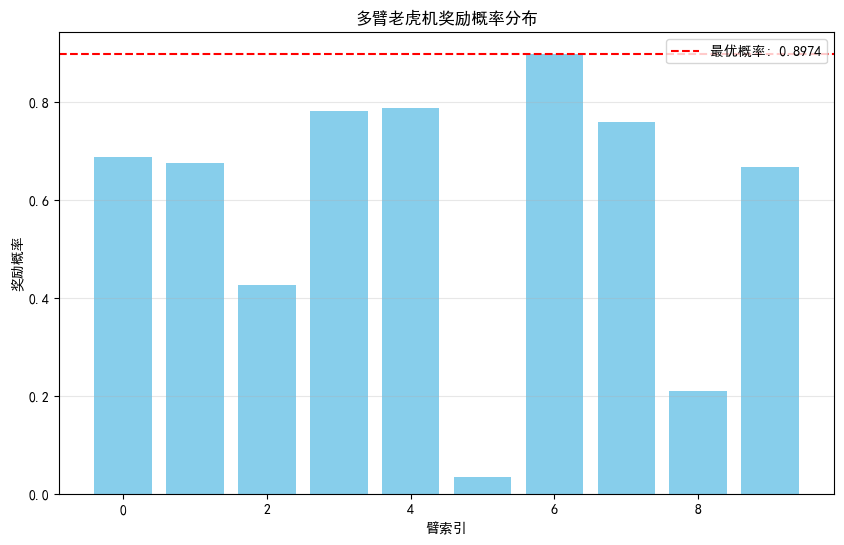


累积奖励: 155.0
累积遗憾: 24.48
每个臂的选择次数: [37 12  5 43  4  2 66 14  3 14]
每个臂的平均奖励: [0.7568 0.75   0.4    0.8372 0.5    0.     0.9091 0.7143 0.     0.5714]


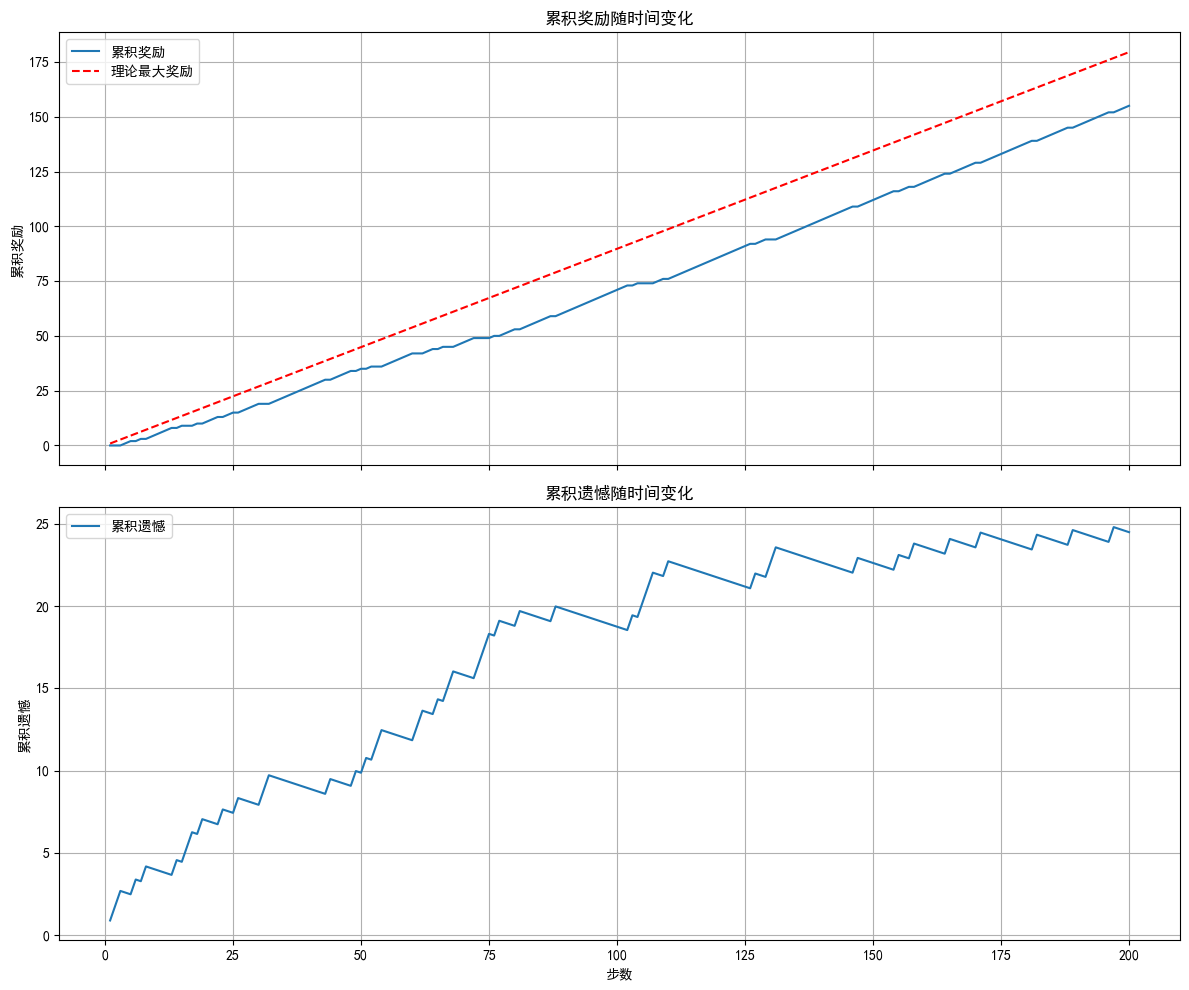

In [44]:
 # 测试代码
if __name__ == "__main__":
    np.random.seed(114514)
    K = 10
    bandit = BernoulliBandit(K)
    print("随机生成了一个10臂伯努利老虎机")
    print(f"获得概率最大的拉杆为{bandit.best_idx}号，其获奖概率为{bandit.best_prob:.4f}")
    # 可视化概率分布
    bandit.plot_probabilities()
    #1
    #epsilon = 0.1
    #solve = Solver1(K)
    #for i in range(200):
    #   if np.random.random() < epsilon:
    #      arm = np.random.randint(K)
        #else:
            #arm = solve.best_idx
        #reward = bandit.step(arm)
        #solver.update(arm, reward)
    #2
    #solve = Thompsonsolver(K)
    #for i in range(200):
    #   arm = ts_solver.pick_arm()
    #    reward = bandit.step(arm)
    #    ts_solver.update(arm, reward)
    #3
    #solve = UCB1solver(K)
    #for i in range(200):
    #    arm = solve.pick_arm(i)
    #    reward = bandit.step(arm)
    #    solve.update(arm, reward)
    solve = Thompsonsolver(K)
    for i in range(200):
       arm = solve.pick_arm()
       reward = bandit.step(arm)
       solve.update(arm, reward)
    print(f"\n累积奖励: {bandit.cumulative_reward}")
    print(f"累积遗憾: {bandit.cumulative_regret:.2f}")
    print(f"每个臂的选择次数: {bandit.counts}")
    print(f"每个臂的平均奖励: {np.round(bandit.values, 4)}")

    # 可视化性能
    bandit.plot_performance()

贝尔曼最优方程：

$$
v_*(s) = \max_{a \in \mathcal{A}(s)} \sum_{s',r} p(s',r|s,a)\Bigl[r + \gamma v_*(s')\Bigr]
$$
无状态（Stateless）: 多臂老虎机问题是一个“无状态”或“单状态”的问题。无论你之前选择了哪个臂，下一次面临的选择都是完全一样的（从K个臂中选择一个）。因此，可以忽略状态 s。

无折扣（Undiscounted）: 在这个问题中，我们关心的是累积总奖励，而不是折扣后的奖励。因此，可以设置折扣因子 γ=1。

无状态转移: 因为没有多个状态，所以也就没有“下一个状态” s' 的概念。

简化后，贝尔曼方程变成了：

$$
v_*(s)=\max\ E[R|a]
$$